# Navier Solution of Simply Supported Beams

In [29]:
import numpy as np

L, d, t = 1000.0, 100.0, 5.0  # geometry
Ex, nu = 210000.0, 0.25  # material

In [30]:
from linkeddeepdict.tools import getallfromkwargs
from sigmaepsilon.solid import BeamSection

# section
section = BeamSection('CHS', d=d, t=t, n=32)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)


## Sinusoidal Loads

$$
\begin{align*}

q_y(x) &= q_{y,max} \, sin \left( n \pi \frac{x}{L} \right) \\

u_y(x) &= \frac{q_{y,max} L^4}{E I_z \pi^4 n^4} sin \left( n \pi \frac{x}{L} \right) \\

\theta_z(x) &= \frac{\partial u_y}{\partial x} = \frac{q_{y,max} L^3}{E I_z \pi^3 n^3} cos \left( n \pi \frac{x}{L} \right) \\

\kappa_z(x) &= \frac{\partial \theta_z}{\partial x} = - \frac{q_{y,max} L^2}{E I_z \pi^2 n^2} sin \left( n \pi \frac{x}{L} \right) \\

M_z(x) &= E I_z \kappa_z(x) = - \frac{q_{y,max} L^2}{\pi^2 n^2} sin \left( n \pi \frac{x}{L} \right) \\

V_y(x) &= - \frac{\partial M_z}{\partial x} = \frac{q_{y,max} L}{\pi n} cos \left( n \pi \frac{x}{L} \right) \\

\end{align*}
$$

In [31]:
qy_max = 1.0 # max intensity
ny = 3  # number of half waves, should be odd


EI = Ex * Iz
PI = np.pi


def qy(x): 
    return np.sin(PI * ny * x / L) * qy_max


def uy(x): 
    return qy_max * (L**4 / (EI * PI**4 * ny**4)) * np.sin(PI * ny * x / L)


def rotz(x): 
    return qy_max * (L**3 / (EI * PI**3 * ny**3)) * np.cos(PI * ny * x / L)


def kz(x): 
    return - qy_max * (L**2 / (EI * PI**2 * ny**2)) * np.sin(PI * ny * x / L)


def mz(x): 
    return - qy_max * (L**2 / (PI**2 * ny**2)) * np.sin(PI * ny * x / L)


def vy(x): 
    return qy_max * (L / (PI * ny)) * np.cos(PI * ny * x / L)



In [32]:
from linkeddeepdict import LinkedDeepDict
from linkeddeepdict.tools import getallfromkwargs
from neumann.linalg import Vector, linspace
from neumann.array import repeat
from polymesh.space import StandardFrame, PointCloud, frames_of_lines
from polymesh.space.utils import index_of_closest_point, index_of_furthest_point
from polymesh.topo.tr import L2_to_L3
from polymesh.utils import cells_coords
from sigmaepsilon.solid.fem.cells.bernoulli import BernoulliBase
from sigmaepsilon.solid.fem.cells import B2, B3
from sigmaepsilon.solid import Structure, LineMesh, PointData, BeamSection
import numpy as np
from typing import Callable

# material
G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])


def solve(n:int, fnc:Callable, celltype:BernoulliBase=B2):
    global i_middle
       
    # space
    GlobalFrame = StandardFrame(dim=3)
    
    # mesh
    p0 = np.array([0., 0., 0.])
    p1 = np.array([L, 0., 0.])
    coords = linspace(p0, p1, n+1)
    topo = np.zeros((n, 2), dtype=int)
    topo[:, 0] = np.arange(n)
    topo[:, 1] = np.arange(n) + 1
    if celltype.NNODE == 3:
        coords, topo = L2_to_L3(coords, topo)
    
    # mark some points
    i_first = index_of_closest_point(coords, np.array([0., 0., 0.]))
    i_last = index_of_furthest_point(coords, np.array([0., 0., 0.]))
    
    # generate load function
    fnc_loads = fnc(coords[:, 0])
        
    # essential boundary conditions
    penalty = 1e20  # penalty value for essential BCs
    fixity = np.zeros((coords.shape[0], 6)).astype(bool)
    fixity[i_first, [0, 1, 2, 3, 4]] = True
    fixity[i_last, [1, 2, 3, 4]] = True
    fixity = fixity.astype(float) * penalty

    # natural boundary conditions
    nodal_loads = np.zeros((coords.shape[0], 6))
    cell_loads = np.zeros((topo.shape[0], topo.shape[1], 6))
    
    # pointdata
    pd = PointData(coords=coords, frame=GlobalFrame,
                   loads=nodal_loads, fixity=fixity)

    # celldata
    frames = repeat(np.eye(3), topo.shape[0])
    cd = celltype(topo=topo, frames=frames)
    cell_loads[:, :, 1] = cd.pull(data=fnc_loads)
    cd.db['loads'] = cell_loads

    # set up mesh and structure
    mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
    structure = Structure(mesh=mesh)

    structure.linsolve()

    return structure


In [33]:
structure = solve(20, qy, B3)
u = structure.nodal_dof_solution(store='dofsol')
u = structure.mesh.cell_dof_solution(points=[1/4, 3/4], rng=[0, 1], target='global')
f = structure.internal_forces(points=[1/4, 3/4], rng=[0, 1], target='global')

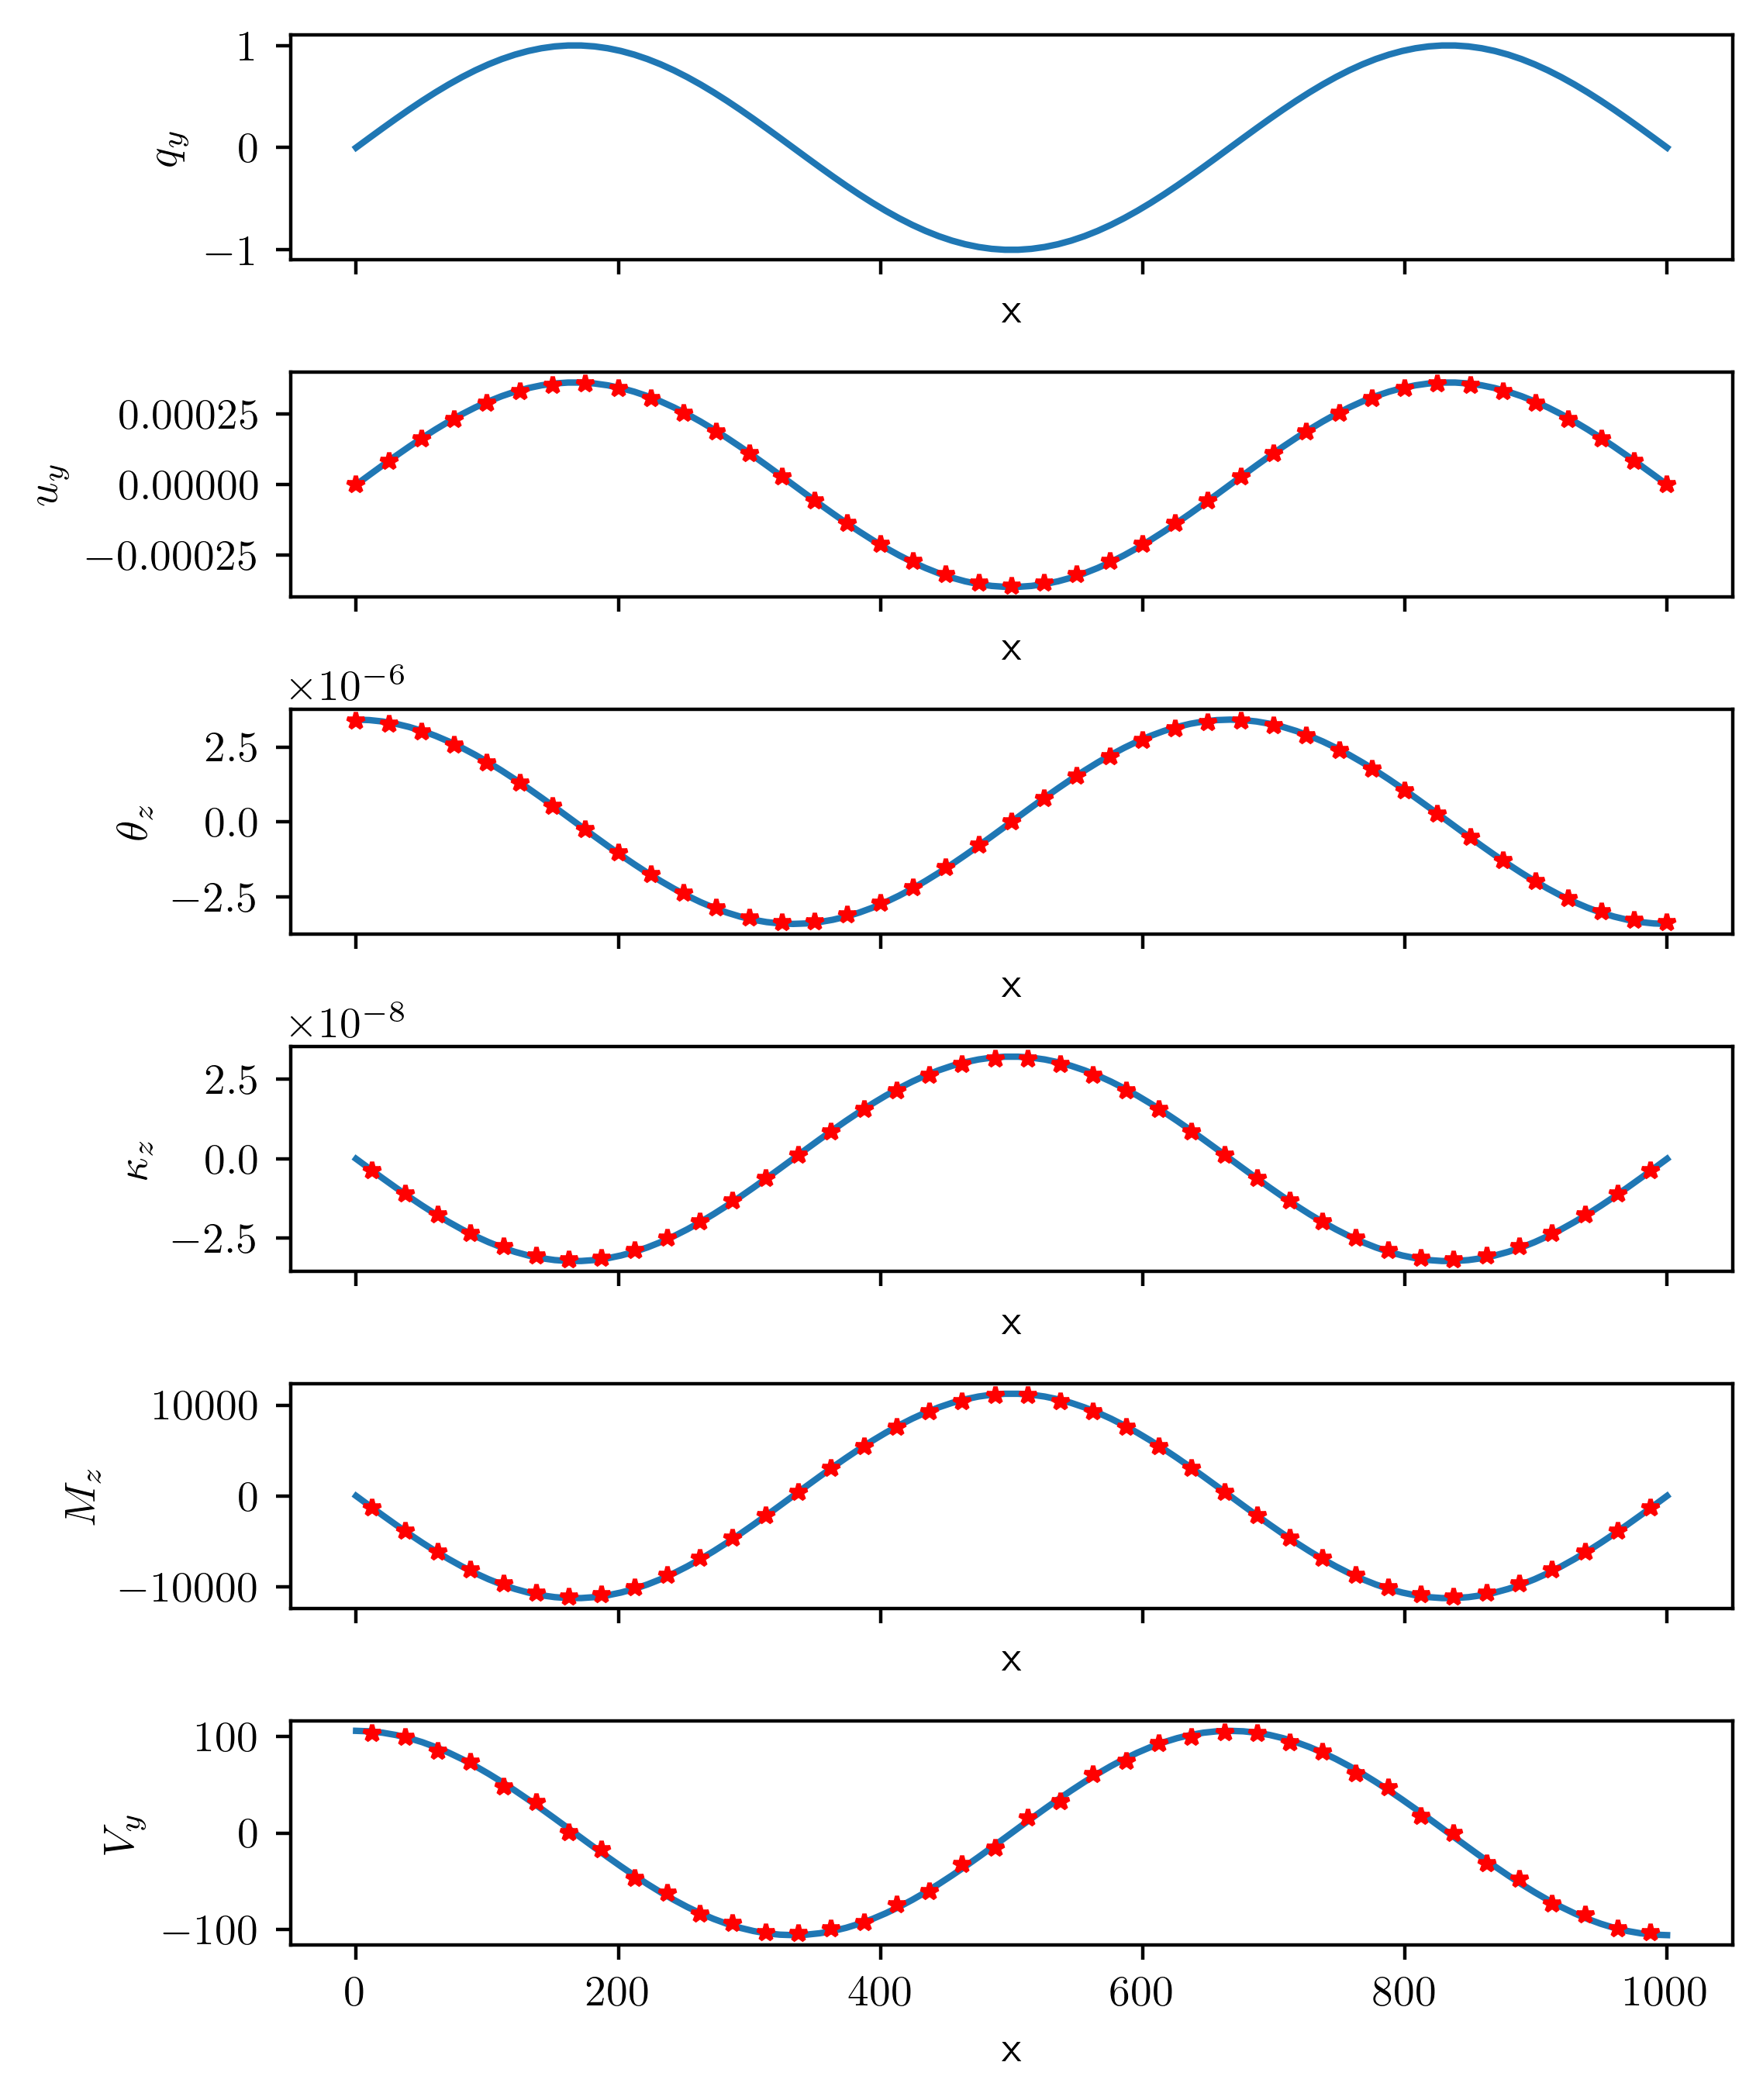

In [34]:
import matplotlib.pyplot as plt

structure = solve(20, qy, B3)
x = structure.mesh.coords()[:, 0]
u = structure.nodal_dof_solution(store='dofsol')
r = structure.reaction_forces()
f = structure.internal_forces(points=[1/4, 3/4], rng=[0, 1])
k = structure.mesh.strains(points=[1/4, 3/4], rng=[0, 1])
xi = structure.mesh.cells_coords(points=[1/4, 3/4], rng=[0, 1])

fig, axs = plt.subplots(6, 1, figsize=(6, 8), dpi=400, sharex=True)

_x = np.linspace(0, L, 100)
ms = 4

axs[0].plot(_x, qy(_x))
axs[0].set_xlabel('$x$')
axs[0].set_ylabel(r'$q_y$')

axs[1].plot(_x, uy(_x))
axs[1].plot(x, u[:, 1], 'r*', markersize=ms)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$u_y$')

axs[2].plot(_x, rotz(_x))
axs[2].plot(x, u[:, -1], 'r*', markersize=ms)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel(r'$\theta_z$')

axs[3].plot(_x, kz(_x))
axs[3].plot(xi[:, :, 0].flatten(), k[:, :, -1].flatten(), 'r*', markersize=ms)
axs[3].set_xlabel('$x$')
axs[3].set_ylabel('$\kappa_z$')

axs[4].plot(_x, mz(_x))
axs[4].plot(xi[:, :, 0].flatten(), f[:, :, -1].flatten(), 'r*', markersize=ms)
axs[4].set_xlabel('$x$')
axs[4].set_ylabel('$M_z$')

axs[5].plot(_x, vy(_x))
axs[5].plot(xi[:, :, 0].flatten(), f[:, :, 1].flatten(), 'r*', markersize=ms)
axs[5].set_xlabel('$x$')
axs[5].set_ylabel('$V_y$')

plt.subplots_adjust(hspace=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

In [35]:
fig.savefig('navier.pdf')